In [45]:
import pandas as pd
import numpy as np
import os
import email
import email.policy
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
import re
import heapq

import matplotlib.pyplot as plt

In [46]:
os.listdir('./Database')

['ham', 'spam']

In [47]:
arquivosNormais = [nomeArquivo for nomeArquivo in (os.listdir("./Database/ham")) if len(nomeArquivo) > 20]
arquivosSpam = [nomeArquivo for nomeArquivo in (os.listdir("./Database/spam")) if len(nomeArquivo) > 20]

emailsNome = arquivosNormais + arquivosSpam

In [48]:
def carregarEmail(tipo, arquivo):
    caminho = ""

    if tipo == "spam":
        caminho = "./Database/spam"
    if tipo == "ham":
        caminho = "./Database/ham"

    with open(f"{caminho}/{arquivo}", "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)


emailsNormais = [carregarEmail("ham", arquivo) for arquivo in arquivosNormais]
emailsSpam = [carregarEmail("spam", arquivo) for arquivo in arquivosSpam]

emails = emailsNormais + emailsSpam

aux = emailsNormais[0]

In [49]:
for i in aux.keys():
    print(f"{i} : {aux[i]}")

print('\n')
print('Conteudo:', aux.get_content())

Return-Path : <exmh-workers-admin@example.com>
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 

In [50]:
def get_email_structure(email):
    if isinstance(email, str):
        return email

    payload = email.get_payload()

    if isinstance(payload, list):
        lista = []
        for sub_email in payload:
            lista.append(get_email_structure(sub_email))

        return "Estruturas do email:", lista

    else:

        return email.get_content_type()


emailsNormaisMultipart = get_email_structure(emailsNormais[634])

In [51]:
emailsNormaisMultipart

('Estruturas do email:', ['text/plain', 'text/html'])

In [52]:

for email in emailsNormais[634].walk():
    print(email)

Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id C2C2316F16
	for <jm@localhost>; Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g8CNsQC20509 for <jm@jmason.org>;
    Fri, 13 Sep 2002 00:54:27 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id A31B02940D3; Thu, 12 Sep 2002 16:51:04 -0700 (PDT)
Delivered-To: fork@example.com
Received: from web13003.mail.yahoo.com (web13003.mail.yahoo.com
    [216.136.174.13]) by xent.com (Postfix) with SMTP id 5696629409A for
    <fork@xent.com>; Thu, 12 Sep 2002 16:50:13 -0700 (PDT)
Message-Id: <20020912235313.4003.qmail@web13003.mail.yahoo.com>
Received: from

In [53]:
def html_to_text(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n', '')
    except:
        return "empty"


def email_to_text(email):
    for emailParts in email.walk():
        if emailParts.get_content_type() not in ['text/plain', 'text/html']:
            continue

        try:
            emailPartsContent = emailParts.get_content()
        except:
            emailPartsContent = str(emailParts.get_payload())

        if emailParts.get_content_type() == 'text/plain':
            return emailPartsContent
        else:
            return html_to_text(emailParts)


'''def email_to_text(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_text(part)'''


"def email_to_text(email):\n    struct = get_email_structure(email)\n    for part in email.walk():\n        partContentType = part.get_content_type()\n        if partContentType not in ['text/plain','text/html']:\n            continue\n        try:\n            partContent = part.get_content()\n        except: # in case of encoding issues\n            partContent = str(part.get_payload())\n        if partContentType == 'text/plain':\n            return partContent\n        else:\n            return html_to_text(part)"

In [54]:
email_to_text(emailsNormais[0])

'    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia.c

In [55]:
def removePunctuation(text):
    ponctuation = list(punctuation)

    for i in ponctuation:
        text = text.replace(i, " ")

    return text


def wordsPreProcessing(email):
    if email is None:
        return 'empty'

    newText = ""

    stopWords = set(stopwords.words('english') + list(STOPWORDS))
    lemmatizer = WordNetLemmatizer()
    wordTokenize = RegexpTokenizer(r'\w+')

    for text in wordTokenize.tokenize(email.lower()):
        text = removePunctuation(text)
        if text not in stopWords and not text.isdigit():
            newText += lemmatizer.lemmatize(text) + " "

    return newText

In [56]:
def bagOfWord(emails):
    wordCount = {}

    for email in emails:
        for i in email.split():
            if i not in wordCount.keys():
                wordCount[i] = 1
            else:
                wordCount[i] += 1

    return wordCount

In [57]:
emailsText = []

for email in emails:
    emailsText.append(wordsPreProcessing
                      (email_to_text(email)))

#print(emailsText)

In [58]:
wordCount = bagOfWord(emailsText)

wordFrequency = heapq.nlargest(100, wordCount, wordCount.get)

print(wordFrequency)

['http', 'com', 'list', 'www', 'net', 'time', 'use', 'rpm', 'message', 'people', 'email', 'like', 'user', 'mail', 'new', 'free', 'linux', 'mailing', 'spamassassin', 'listinfo', 'e', 'wrote', 'year', 'work', 'date', 'html', 'file', 'exmh', 'click', 'world', 'way', 'state', 'said', 'freshrpms', 'company', 'org', 'spam', 'think', 'url', 'want', 'c', 'group', 'right', 'money', 'need', 'mailman', 'r', 'information', 'know', 'business', 'problem', 'line', 'sourceforge', 'day', 'thing', 'service', 'perl', 'address', 'good', 'report', 'razor', 'change', 'home', 'talk', 'technology', 'order', 'internet', 'government', 'send', 'run', 'redhat', 'help', 'package', 'software', 'mv', 'data', 'web', 'network', 'best', 'subject', 'program', 'site', 'yahoo', 'link', 'look', 'fork', 'set', 'check', 'number', 'news', 'sep', 'sf', 'l', 'xml', 'old', 'phone', 'life', 'server', 'today', 'country']


In [59]:
tfidfVectorizer = TfidfVectorizer(analyzer="word", max_features=1000)

tfidfTransform = tfidfVectorizer.fit_transform(emailsText)

print(tfidfTransform)

  (0, 493)	0.031718768954327875
  (0, 518)	0.03663330405274946
  (0, 494)	0.05801063129132526
  (0, 395)	0.01796689342996931
  (0, 722)	0.10468005176723007
  (0, 517)	0.03233708567995432
  (0, 981)	0.1956457461897728
  (0, 277)	0.16604423420083977
  (0, 890)	0.040571993359197124
  (0, 440)	0.051807802468495305
  (0, 501)	0.05801063129132526
  (0, 903)	0.04824478004669521
  (0, 185)	0.06276009393202762
  (0, 709)	0.06699698589466922
  (0, 2)	0.05781013053758274
  (0, 26)	0.058949563949551025
  (0, 193)	0.04478636389281222
  (0, 315)	0.05187325232256284
  (0, 142)	0.050678418699149186
  (0, 178)	0.06925477896467115
  (0, 770)	0.063189332024574
  (0, 489)	0.044393098049241644
  (0, 12)	0.050498601762735525
  (0, 979)	0.03940521062434357
  (0, 548)	0.152611674453085
  :	:
  (3051, 515)	0.010097453200693135
  (3051, 391)	0.041971265196574556
  (3051, 366)	0.015303153068895143
  (3051, 721)	0.029674549883991392
  (3051, 60)	0.013432969709536027
  (3051, 870)	0.06713794500297317
  (3051, 937)

In [60]:
tfidfLabels = tfidfVectorizer.get_feature_names_out()
tfidfLabels

array(['7gsolb', 'ability', 'able', 'absolutely', 'ac', 'accept',
       'access', 'according', 'account', 'act', 'action', 'activity',
       'actually', 'ad', 'adam', 'add', 'added', 'additional', 'address',
       'admin', 'administration', 'advantage', 'advertising', 'age',
       'agency', 'agent', 'ago', 'agree', 'aid', 'air', 'alb', 'allow',
       'ally', 'alsa', 'alternative', 'america', 'american', 'answer',
       'apparently', 'appear', 'application', 'approach', 'apt',
       'archive', 'area', 'argument', 'article', 'ask', 'asked', 'asp',
       'assistance', 'associate', 'assume', 'atoll', 'attack', 'attempt',
       'au', 'aug', 'august', 'author', 'available', 'average', 'aware',
       'away', 'backup', 'bad', 'bank', 'base', 'based', 'basic',
       'beberg', 'begin', 'behalf', 'believe', 'benefit', 'best',
       'better', 'big', 'billion', 'bin', 'bit', 'bitbitch', 'black',
       'blog', 'body', 'boing', 'boingboing', 'bonus', 'book', 'boston',
       'box', 'brea

In [61]:
dfTfidfArray = pd.DataFrame(data=tfidfTransform.toarray(), index=emailsNome, columns=tfidfLabels)

In [62]:
dfTfidfArray

,7gsolb,ability,able,absolutely,ac,accept,access,according,account,act,...,wrote,www,xent,ximian,xml,yahoo,year,yes,york,young
0001.ea7e79d3153e7469e7a9c3e0af6a357e,0.000000,0.000000,0.057810,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0
0002.b3120c4bcbf3101e661161ee7efcb8bf,0.160172,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.555566,0.000000,0.0,0.00000,0.0
0003.acfc5ad94bbd27118a0d8685d18c89dd,0.073458,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.254792,0.000000,0.0,0.00000,0.0
0004.e8d5727378ddde5c3be181df593f1712,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.037889,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0
0005.8c3b9e9c0f3f183ddaf7592a11b99957,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.057777,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0496.e995facc5d5bc6d3f3a8537d35e0432a,0.000000,0.059078,0.000000,0.061095,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.078302,0.0,0.00000,0.0
0497.9307bd1fb5347f9fbf1f54ebe95b1d20,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.033497,0.0,0.0,0.0,0.000000,0.030349,0.0,0.04921,0.0
0498.863566df8e5f17f979edca79d1e87187,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.066385,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0
0499.4a17fbd7fe71705e09b4dd2e24d802dd,0.000000,0.000000,0.000000,0.000000,0.0,0.153773,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0


In [63]:
arrayTargetsNormais = [0 for _ in arquivosNormais]

arrayTargetsSpam = [0 for _ in arquivosSpam]

targetsArray = arrayTargetsNormais + arrayTargetsSpam

print(len(targetsArray))
print(targetsArray)

3052
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [64]:
dfTfidfArray.insert(len(dfTfidfArray.columns), "target", targetsArray, True)

dfTfidfArray

,7gsolb,ability,able,absolutely,ac,accept,access,according,account,act,...,www,xent,ximian,xml,yahoo,year,yes,york,young,target
0001.ea7e79d3153e7469e7a9c3e0af6a357e,0.000000,0.000000,0.057810,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0
0002.b3120c4bcbf3101e661161ee7efcb8bf,0.160172,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.555566,0.000000,0.0,0.00000,0.0,0
0003.acfc5ad94bbd27118a0d8685d18c89dd,0.073458,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.254792,0.000000,0.0,0.00000,0.0,0
0004.e8d5727378ddde5c3be181df593f1712,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.037889,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0
0005.8c3b9e9c0f3f183ddaf7592a11b99957,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0496.e995facc5d5bc6d3f3a8537d35e0432a,0.000000,0.059078,0.000000,0.061095,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.078302,0.0,0.00000,0.0,0
0497.9307bd1fb5347f9fbf1f54ebe95b1d20,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.033497,0.0,0.0,0.0,0.000000,0.030349,0.0,0.04921,0.0,0
0498.863566df8e5f17f979edca79d1e87187,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.066385,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0
0499.4a17fbd7fe71705e09b4dd2e24d802dd,0.000000,0.000000,0.000000,0.000000,0.0,0.153773,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0


In [65]:
dfTfidfArray.to_csv("dataset.csv", sep='\t', encoding='utf-8')

E:\Anaconda3\envs\ciencia_de_dados_data_analysis\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Anaconda3\envs\ciencia_de_dados_data_analysis\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


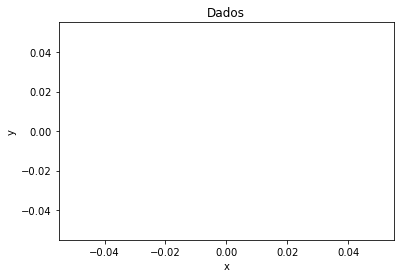

In [67]:
model = TSNE(n_components=2, random_state=0)
array_red = model.fit_transform(dfTfidfArray)

df_tsne = pd.DataFrame(array_red)

dfTfidfArray.columns = dfTfidfArray.columns.str.strip()

target = targetsArray

df_tsne['target'] = target

df_tsne_c1 = df_tsne[df_tsne['target'] == 'Normal']

df_tsne_c2 = df_tsne[df_tsne['target'] == 'SPAM']

plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')

plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')

plt.title('Dados')
plt.xlabel('x')
plt.ylabel('y')

plt.show()